**Ensemble of InceptionResNetV2 and Xception, image resized by following the Central Tendency (to 375,500) trained for 12 Epochs using SGD Optimizer LR = 0.01 with a Validation Accuracy of 93.93%**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import seaborn as sns
%matplotlib inline

import tensorflow as tf

import sklearn

import os
import shutil

In [4]:
labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 10222 entries, 0 to 10221

Data columns (total 2 columns):

 #   Column  Non-Null Count  Dtype 

---  ------  --------------  ----- 

 0   id      10222 non-null  object

 1   breed   10222 non-null  object

dtypes: object(2)

memory usage: 159.8+ KB


In [5]:
data = pd.DataFrame(columns = ['filename','label'])

data['filename'] = labels['id'] + '.jpg'
data['label'] = labels['breed']

data.sample(10)

,filename,label
10103,fd03162f0a586bbeac13c33e74d24e73.jpg,otterhound
3749,5d35302836df23812a233888a6309892.jpg,silky_terrier
5244,843cbc1fc239d24534859bd272c3bc16.jpg,norfolk_terrier
926,16acaa39e4fe4edbc2becbeb85e8ccbe.jpg,standard_schnauzer
3292,51cf930fcaa72551347eaed4b2e08f1b.jpg,toy_poodle
2430,3c6ec531552c07c174a2fb1b2284c7e4.jpg,pembroke
9665,f343a8b0d587a5f79c7da06732fcb347.jpg,labrador_retriever
4302,6b3ec7c2f0c3101082258b67b9966134.jpg,weimaraner
9146,e5ceecb78014cf7eb9bed9a6ce23dbf0.jpg,saluki
2454,3d24ce4a94e4763049d60425cb3e75ae.jpg,miniature_poodle


In [6]:
batch_size = 64
target_size = (375,500)
input_shape = (375,500,3)

**Defining Image Data Generator and Train Val Datasets**

In [7]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1)

In [8]:
train_idg = idg.flow_from_dataframe(dataframe = data, directory = "/kaggle/input/dog-breed-identification/train/",
                                    x_col="filename", y_col="label",
                                    target_size = target_size,
                                    batch_size = batch_size,
                                    subset="training")

Found 9200 validated image filenames belonging to 120 classes.


In [9]:
val_idg = idg.flow_from_dataframe(dataframe = data, directory = "/kaggle/input/dog-breed-identification/train/",
                                    x_col="filename", y_col="label",
                                    target_size = target_size,
                                    batch_size = batch_size,
                                    subset="validation")

Found 1022 validated image filenames belonging to 120 classes.


In [10]:
inception_no_top = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top = False, input_shape = input_shape)
xception_no_top = tf.keras.applications.xception.Xception(include_top = False, input_shape = input_shape)


219055592/219055592 [==============================] - 11s 0us/step


83683744/83683744 [==============================] - 5s 0us/step


In [11]:
inception_no_top.input_shape, inception_no_top.output_shape

((None, 375, 500, 3), (None, 10, 14, 1536))

In [12]:
xception_no_top.input_shape, xception_no_top.output_shape

((None, 375, 500, 3), (None, 12, 16, 2048))

**Ensembling for feature extraction**

In [13]:
from keras.applications import inception_resnet_v2
from keras.utils.traceback_utils import include_frame

# 1. Input Layer
input = tf.keras.layers.Input(input_shape, name = "Input_Layer")

# 2. InceptionResNetV2
# 2.1 Preprocessing InceptionResNetV2 using Lambda layer
inception_pre_process = tf.keras.layers.Lambda(tf.keras.applications.inception_resnet_v2.preprocess_input,
                                               name = "Inception_PreProcess") (input)
# 2.2 Get IncpetionResNetV2 Model
inception_model = inception_no_top
inception_model.trainable = False

#2.2.1 Pass InceptionReseNetV2 Model through functional model by linking to preprocess layer
inception = inception_model (inception_pre_process)

# 2.3 Global Average Pooling
inception_avg = tf.keras.layers.GlobalAveragePooling2D(name="InceptionGAP") (inception)

# 3. Xception
# 3.1 Preprocessing Xception using Lambda layer
xception_pre_process = tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input,
                                               name = "Xception_PreProcess") (input)
# 3.2 Get Xception Model
xception_model = xception_no_top
xception_model.trainable = False

#3.2.1 Pass Xception Model through functional model by linking to preprocess layer
xception = xception_model (xception_pre_process)

# 3.3 Global Average Pooling
xception_avg = tf.keras.layers.GlobalAveragePooling2D(name="XceptionGAP") (xception)

# 4. Ensemble Features of InceptionResnetV2 and Xception
concat = tf.keras.layers.Concatenate(name = "Concat") ([inception_avg, xception_avg])

# 5. Connecting the Dense and Output Layers
dense1 = tf.keras.layers.Dense(512, activation = tf.keras.activations.relu, name = "Dense_1") (concat)
dense2 = tf.keras.layers.Dense(512, activation = tf.keras.activations.relu, name = "Dense_2") (dense1)
output = tf.keras.layers.Dense(120, activation="softmax", name="Output") (dense2)

In [14]:
# Assembling the Ensemble and Summarizing
final_model = tf.keras.models.Model(inputs= [input],outputs= [output])
final_model.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 Input_Layer (InputLayer)       [(None, 375, 500, 3  0           []                               

                                )]                                                                

                                                                                                  

 Inception_PreProcess (Lambda)  (None, 375, 500, 3)  0           ['Input_Layer[0][0]']            

                                                                                                  

 Xception_PreProcess (Lambda)   (None, 375, 500, 3)  0           ['Input_Layer[0][0]']            

                                                                                                  

 inception_resnet_v2 (Functiona  (None, 10, 14, 1536  54336736   ['Inception_PrePro

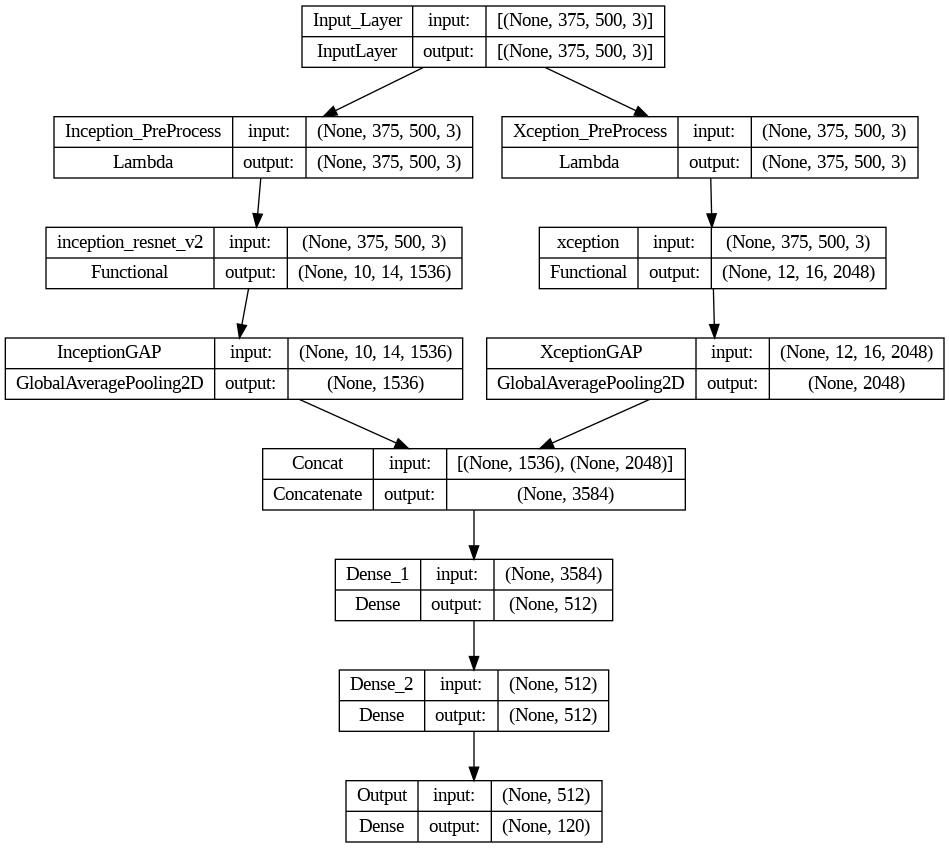

In [15]:
tf.keras.utils.plot_model(final_model, show_shapes = True, show_layer_names=True)

In [16]:
# Compiling the model
final_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics = ["acc"])

In [17]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                                 verbose=0, mode='min')

mcp_save = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True,
                                              monitor='val_loss', mode='min')

reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                      patience=3, verbose=1, min_delta=1e-4, mode='min')

callbacks = [earlyStopping, mcp_save, reduce_lr_loss]

In [18]:
%%time
final_model.fit(train_idg, batch_size=batch_size, validation_data=val_idg, epochs=12, callbacks = callbacks)

Epoch 1/12

144/144 [==============================] - 449s 3s/step - loss: 4.7173 - acc: 0.0635 - val_loss: 4.6420 - val_acc: 0.1458 - lr: 0.0100

Epoch 2/12

144/144 [==============================] - 363s 3s/step - loss: 4.5384 - acc: 0.2659 - val_loss: 4.4354 - val_acc: 0.3748 - lr: 0.0100

Epoch 3/12

144/144 [==============================] - 367s 3s/step - loss: 4.2828 - acc: 0.5009 - val_loss: 4.1337 - val_acc: 0.5528 - lr: 0.0100

Epoch 4/12

144/144 [==============================] - 363s 3s/step - loss: 3.9209 - acc: 0.6466 - val_loss: 3.7157 - val_acc: 0.6957 - lr: 0.0100

Epoch 5/12

144/144 [==============================] - 367s 3s/step - loss: 3.4333 - acc: 0.7495 - val_loss: 3.1677 - val_acc: 0.7877 - lr: 0.0100

Epoch 6/12

144/144 [==============================] - 368s 3s/step - loss: 2.8228 - acc: 0.8198 - val_loss: 2.5084 - val_acc: 0.8523 - lr: 0.0100

Epoch 7/12

144/144 [==============================] - 368s 3s/step - loss: 2.1454 - acc: 0.8648 - val_loss: 1.8

Text(0.5, 1.0, 'Accuracy of Model')

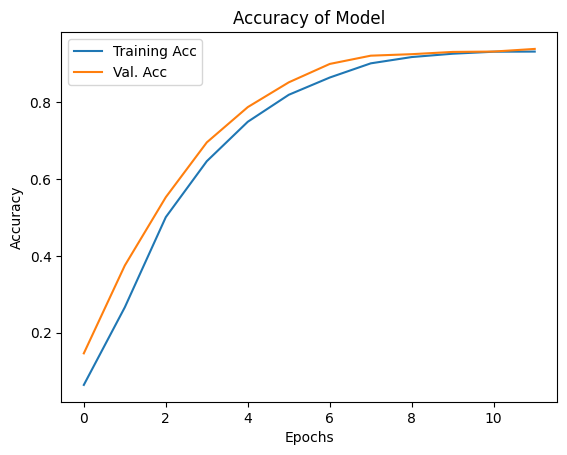

In [19]:
plt.plot(final_model.history.history["acc"], label = "Training Acc")
plt.plot(final_model.history.history["val_acc"], label = "Val. Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Model")

Text(0.5, 1.0, 'Loss - Training vs Validation')

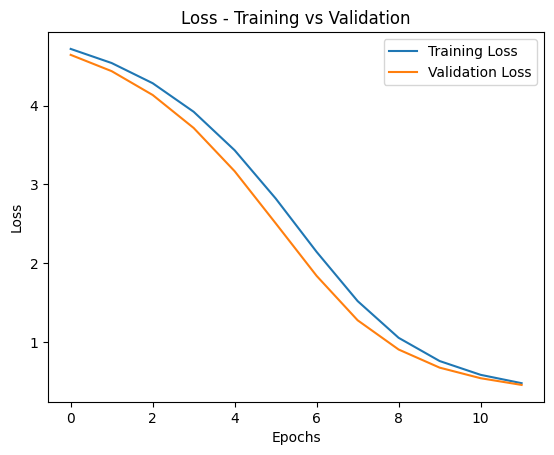

In [20]:
plt.plot(final_model.history.history["loss"], label = "Training Loss")
plt.plot(final_model.history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss - Training vs Validation")

In [21]:
loss = final_model.history.history["loss"]
val_loss = final_model.history.history["val_loss"]
acc = final_model.history.history["acc"]
val_acc = final_model.history.history["val_acc"]

# Create the DataFrame
model_perf = pd.DataFrame({
    "Training_Loss": loss,
    "Validation_Loss": val_loss,
    "Training_Accuracy": acc,
    "Validation_Accuracy": val_acc
})

model_perf.insert(0, "Epoch", range(1, len(model_perf) + 1))

In [22]:
model_perf.to_csv('Ensemble_6.csv',index=False)